<div style="text-align: center;">
    <img src="Banner.jpg" width="100%" height="auto"/>
</div>

**Disclaimer**: This notebook was written on AWS utilizing a Pyspark kernel. This notebook was not meant to be run from top to bottom. Should you wish to see the code for the project in detail please refer to the supplementary notebook.

In [1]:
# sc.install_pypi_package("pandas==2.0.2")
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")
# sc.install_pypi_package("seaborn")
# sc.install_pypi_package("tensorflow==2.15.0")
sc.install_pypi_package("boto3")
sc.install_pypi_package("pyarrow==14.0.2")
sc.install_pypi_package("pillow==9.4.0")
# sc.install_pypi_package("opencv-python")
sc.install_pypi_package("plotly")

VBox()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1718257467665_0007/container_1718257467665_0007_01_000001/tmp/spark-e20e2674-8fc4-4e3e-9516-8d204e2ce8fa
    Can't uninstall 'python-dateutil'. No files were found to uninstall.




  Attempting uninstall: pillow
    Found existing installation: pillow 10.3.0
    Uninstalling pillow-10.3.0:
      Successfully uninstalled pillow-10.3.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.






In [2]:
import io
import os
from glob import glob
from io import BytesIO

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import tensorflow as tf
from PIL import Image
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vector, Vectors, VectorUDT
from pyspark.sql import Row, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    ArrayType,
    DoubleType,
    FloatType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)

# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.layers import Rescaling, Resizing

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<div class="custom-header">
    <h1 class="small-caps">Table of Contents</h1>
</div>

<a name="top"></a>

[ref1]: #abstract
[1. Abstract][ref1]

[ref2]: #background
[2. Background][ref2]

[ref3]: #problem_statement
[3. Problem Statement][ref3]

[ref4]: #motivation
[4. Motivation][ref4]

[ref5]: #data_source
[5. Data Source][ref5]

[ref6]: #data_exploration
[6. Data Exploration][ref6]

[ref7]: #methodology
[7. Methodology][ref7]

[ref8]: #implemenation
[8. Implementation][ref8]

[ref9]: #results
[9. Results and Discussion][ref9]

[ref10]: #conclusion
[10. Conclusion][ref10]

[ref11]: #recommendations
[11. Recommendations][ref11]

[ref12]: #references
[12. References][ref12]

[ref13]: #appendix
[12. Appendix][ref13]

<div class="custom-header">
    <h1 class="small-caps"><a name='abstract'>Abstract</a></h1>
</div>

This study introduces a novel hybrid pipeline approach for unsupervised learning, applied to big data analysis on AWS PySpark. Leveraging VGG16 for feature extraction from a dataset of synthetically generated images, we successfully clustered the images into two distinct categories: well-generated, defined images, and distorted ones. Further analysis revealed subclusters within these categories, indicating nuanced differences in image quality.

The ability to generate subclasses within synthetic data, without relying on pre-labeled datasets, could revolutionize the AI development landscape. It promises to alleviate the current bottleneck of manual data labeling, significantly reducing development costs and timelines. Smaller players in the AI field could benefit immensely from this approach, leveling the playing field and fostering innovation.

Moreover, this research has far-reaching implications for large language models (LLMs) and generative AI. Unsupervised labels generated through this method could be used to fine-tune these models, leading to significant improvements in various domains.  This opens the door for AI systems that not only process information but actively refine their understanding of the world through unsupervised learning.

While this study marks a preliminary step, the implications are profound. By introducing this simple yet potentially effective technique, we pave the way for a more efficient, inclusive, and advanced future for artificial intelligence.



[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='background'>Background</a></h1>
</div>

Generative Artificial Intelligence, colloquilaly known as 'Gen AI' has swept up the world its awe-inspiring convenience and "intelligence". Offering quick and easy responses to most questions people would ask. It is capable of a multitude of tasks, ranging from arithmetic, planning your next vacation itinerary, to checking your grammar. That is the front-end of Gen AI, a virtual assistant that can answer most if not all of your questions. What doesn't get spoken about often however, is how these Artificial Intelligence applications got to the level of usability they have today. These technologies require data numbering in the millions, even billions, to get to where they are today. Dall-e, OpenAI's diffusion model, required around four-hundred-million image-caption pairs to get to its base level of functionality today.

As mentioned the images fed to a diffusion model like Dall-e requires the images to be properly captioned or 'labeled', and this task of labelling can be quite laborious and very costly. ImageNet, a popular image database, had its contributors manually label and annotate more than fourteen-million images for nine years. A herculean task if ever there was one. Next, in terms of cost, Amazon SageMaker offers labelling services at 0.012 USD per label, Dall-e alone would have taken 4.8 million USD to label. Having properly labelled data right from the start would be considered a blessing by most Data Scientists, but this is not always the case and so there becomes this problem of being able to manage the time and resources necessary to produce datasets that meet the needs of training these technologies.

The challenges of manually labeling the massive datasets required for training Generative AI, as highlighted by the ImageNet and Dall-e examples, are where Big Data truly comes into play. With its vast repositories of information, Big Data presents an opportunity to expedite and scale the labeling process. Instead of relying solely on manual annotation, Big Data can provide a wealth of pre-existing data, such as images with associated metadata or user-generated tags. While not always perfectly accurate, this data can serve as a starting point for training models, reducing the need for extensive manual labeling. Additionally, Big Data enables active learning approaches, where models themselves can suggest which data points would be most informative for humans to label, optimizing the annotation effort. This combination of scale, diversity, and intelligent selection offered by Big Data significantly eases the burden of labeling and accelerates the development of more powerful and capable Generative AI models.

[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='problem_statement'>Problem Statement</a></h1>
</div>

With labelling being such a resource-intensive process, we can make use of current machine learning processes and technologies and achieve Data Enrichment (Allen & Cervo, 2015). This is to enrich and improve the accuracy and quality of Big Data, in this case by improving the way by which we tag and classify data (Krishnan, 2013). To this end the team has sought out current technologies and Data Science applications to address this challenge and has framed this problem under this statement:

**How might we enrich existing datasets for more complex Generative AI and Computer Vision applications?**

[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='motivation'>Motivation</a></h1>
</div>

As previously discussed the task of labelling is both costly and time-consuming, making the task of training and further fine-tuning ones own datasets a difficult endeavor. Large companies who have access to resources as large as the data they are processing, are not as burdened by such a dilemma. However as individual data scientists or users, who do not have that kind of luxury what options are there then? The team is then interested to further democratize the process and explore a methodology that will be more convenient and less resource intensive to perform on the volume of data necessary to train generative technologies.

[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='data_source'>Data Source</a></h1>
</div>

It is a purely synthetic dataset compiled by user MISTEICK on Kaggle called [1 million cats](https://www.kaggle.com/datasets/chelove4draste/1-million-cats). It contains around nine-hundred-ninety-four-thousand cat generated cat images. The images were generated by making use of a custom implementation of [StyleGAN2](https://github.com/adriansahlman/stylegan2_pytorch), a generative adversarial network.  Each image was generated as a png, and labeled sequentially. Each image followed the naming convention of `seed0000.png`.

The data in 101 Gigabytes in size and only 52GB of it was used for ease of handling and processes. In terms of number of images this is five-hundred-fifty-thousand cat images. 
    
[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='data_exploration'>Data Exploration</a></h1>
</div>

As seen in **Figure 1.** and **Figure 2.** All images are of 256 by 256 dimension.

<div style="display: flex; justify-content: center; align-items: center; flex-wrap: wrap;">
    <figure style="width: 50%; margin: 10px;">
        <img src="width.jpeg" style="width: 100%;"/>
        <figcaption style="text-align: center;"><strong>Figure 1</strong>. Image Width</figcaption>
    </figure>
    <figure style="width: 50%; margin: 10px;">
        <img src="height.jpeg" style="width: 100%;"/>
        <figcaption style="text-align: center;"><strong>Figure 2</strong>. Image Height</figcaption>
    </figure>
    <!-- Repeat for each image -->
</div>

In [13]:
import random

features_df = spark.read.parquet(
    "s3a://bdcc2024-cpt5-finalproject/cats_550k_features-parquet*/*.parquet")

random_sample = features_df.sample(withReplacement=False,
                                   fraction=0.01,
                                   seed=74797569)

df_rando = (
    random_sample.withColumn(
        'fpath', 
        F.regexp_extract('image_path', r"cats_550k/.+", 0)
    )
            .select('fpath')
            .limit(500)
            .collect()
)

rando = [Row['fpath'] for Row in df_rando]

bucket_name = 'bdcc2024-cpt5-finalproject'
random.seed(0)
rando_30 = random.sample(rando, k=30)
cluster_images = rando_30

# Define the grid size for displaying images
ncols = 5  # This sets the number of columns
nrows = 6

# Create a figure with a specified size
plt.figure(figsize=(20, 18))  # width x height

# Initialize S3 client
s3_client = boto3.client('s3')

# Loop through each image path in fpath_list, limiting the number of images
for i, image_key in enumerate(cluster_images):
    try:
        # Download the image object from S3
        image_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        image_content = image_object['Body'].read()

        # Load image into PIL
        image = Image.open(BytesIO(image_content))

        # Add subplot for the image
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.title(image_key.split('/')[-1])  
    except Exception as e:
        print(f"Error loading image {image_key}: {e}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Already we can see some cat images in **Figure 3.** with similar patterns that the clustering may or may not take into consideration. There are some cats who share similar coloration of their fur as well pattern. However it is also noted that some of the cats are generated quite poorly, with significantnly morphed features being apparent. This may become problematic should the cluster not be able to recognize these features and rely solely on the colorations and such when performing the grouping of the different clusters.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

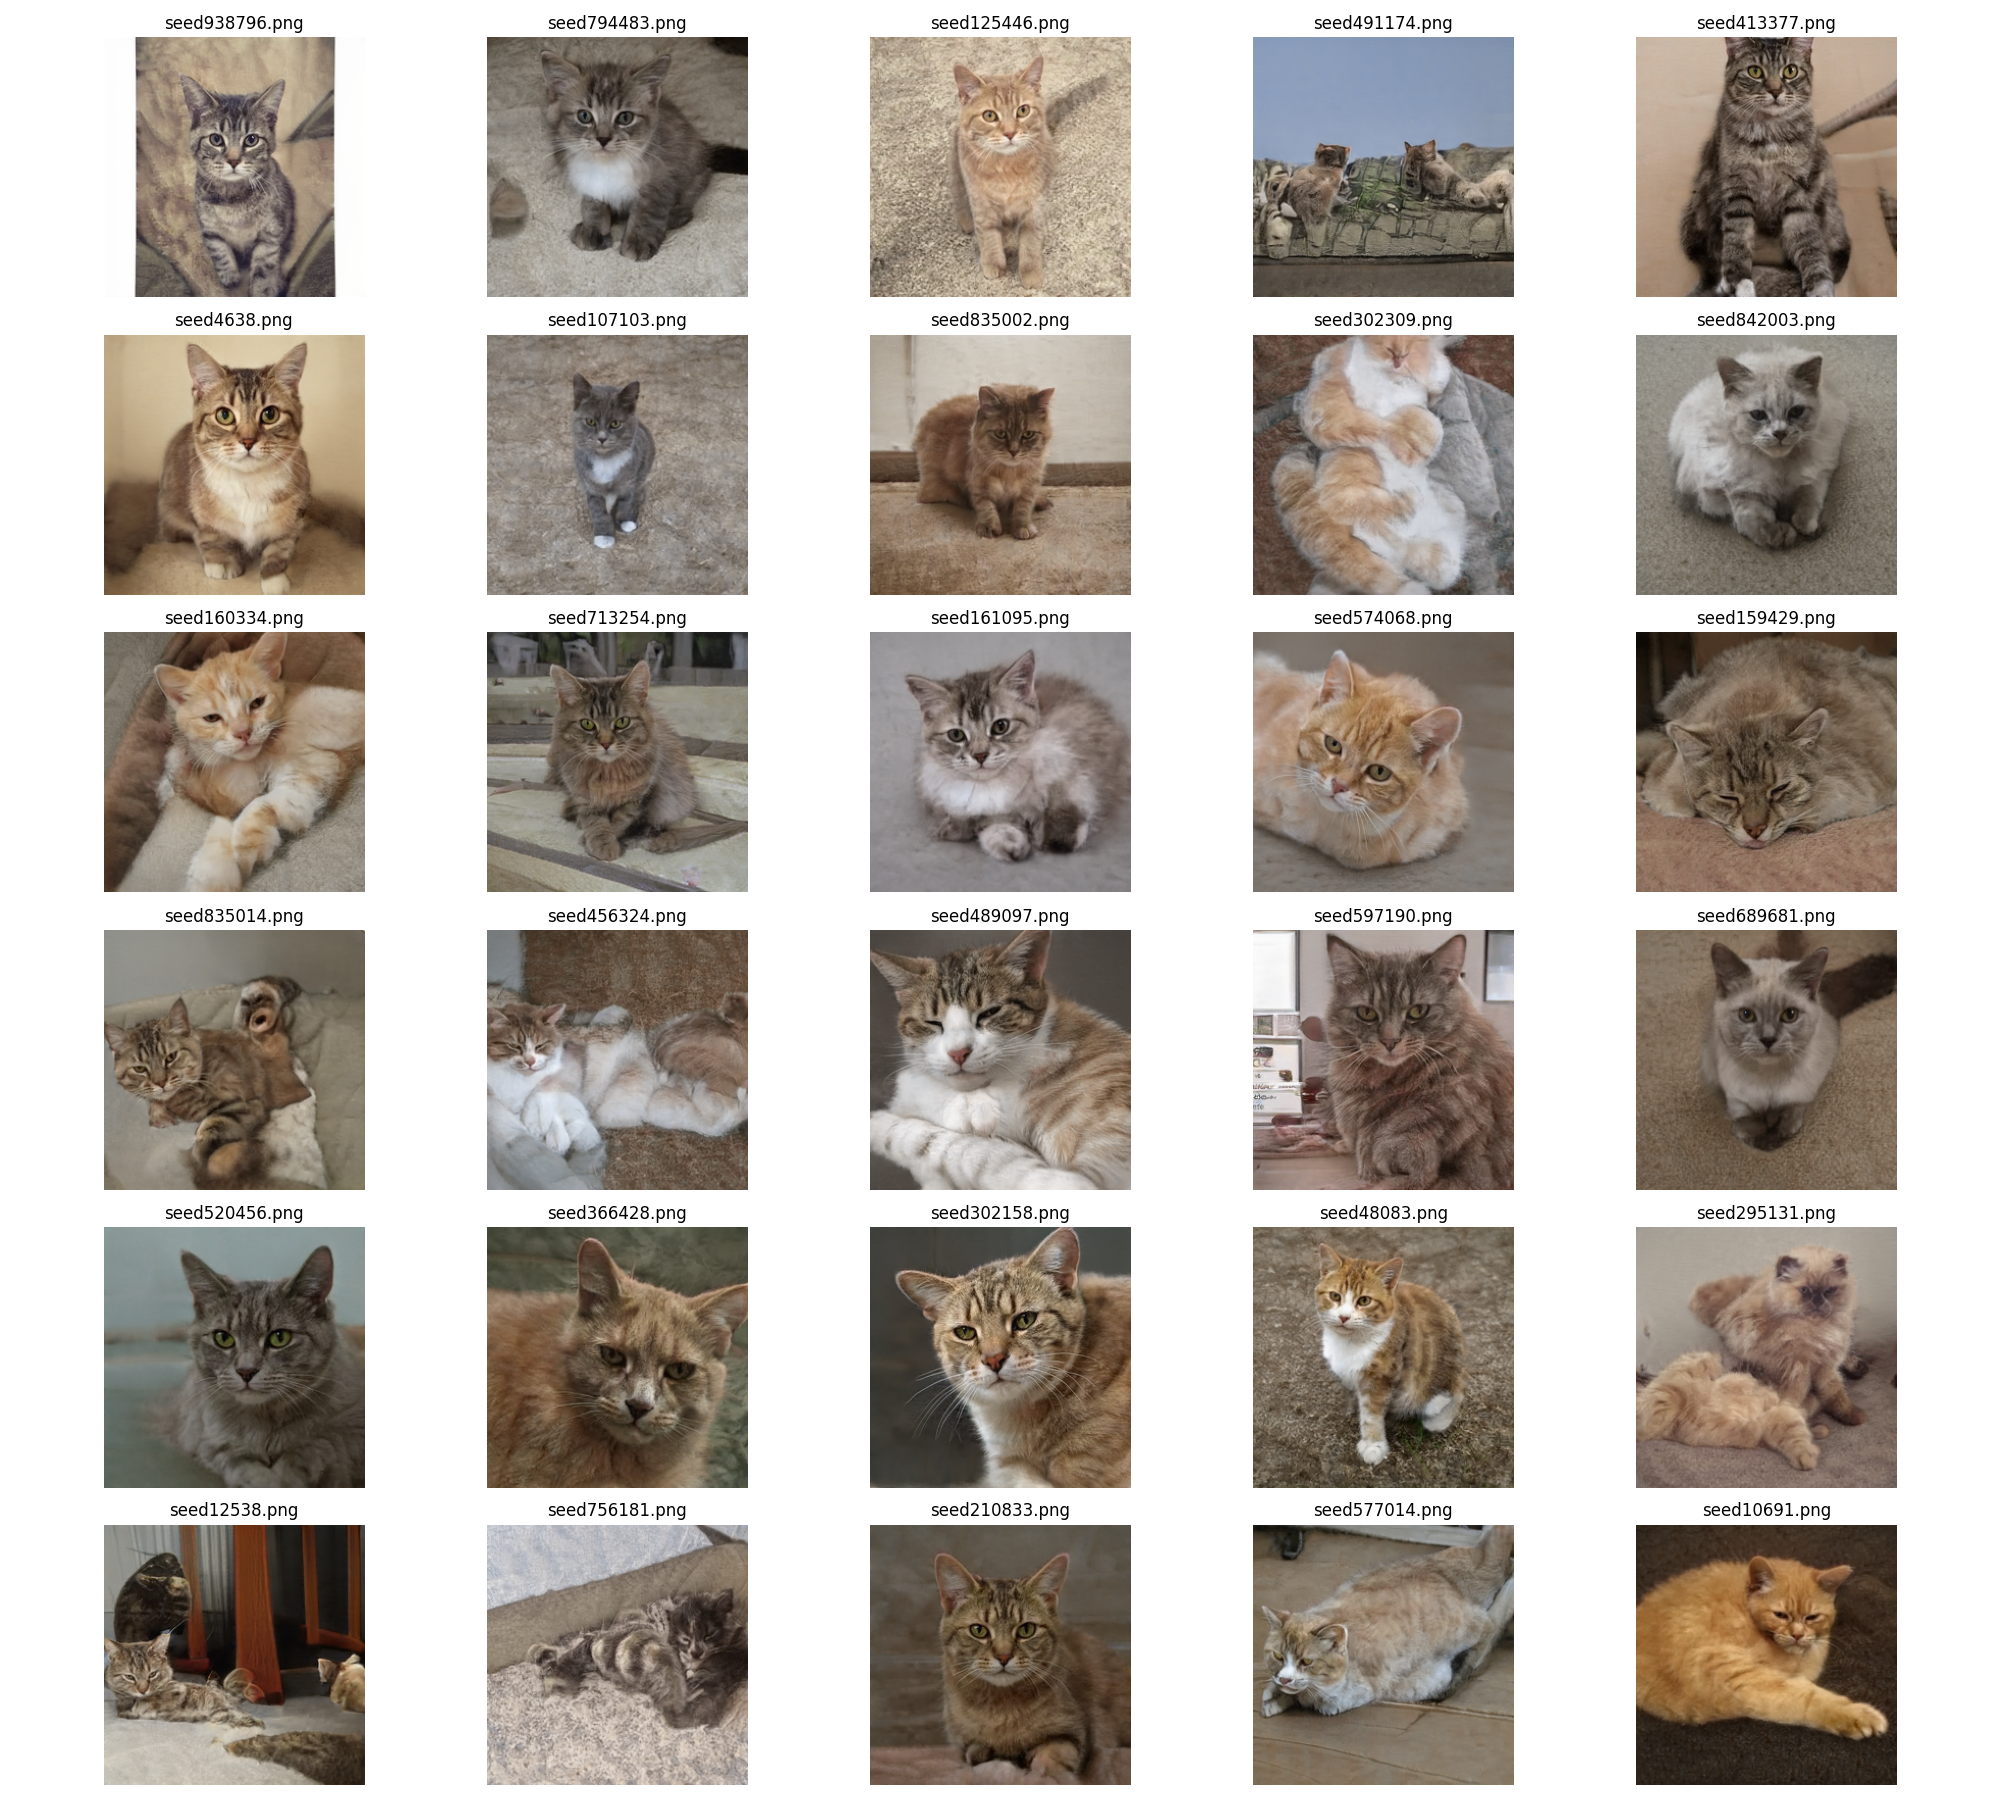

In [14]:
%matplot plt

<center><b>Figure 3.</b>Randomly Selected Images from Dataset</center>



[ref]: #top
[Back to Table of Contents][ref]

## Handling Big Data through Cloud Computing

Given that the size of the data is quite large, all data was handled through cloud computing via Amazon Web Services on a Pyspark notebook. The team made use of 16 m5.xlarge instances.  It is in the general purpose family with 4 vCPUs, 16.0 GiB of memory and up to 10 Gibps of bandwidth starting at **0.192 USD** per hour and instnace, for on-demand usage. All files were stored on an S3 bucket. It charges **0.023 USD** per GB/month for the first 50 Terrabytes of data. 

<div class="custom-header">
    <h1 class="small-caps"><a name='methodology'>Methodology</a></h1>
</div>

<div style="text-align: center;">
    <img src="CatsMethoOverview.png" width="50%" height="auto"/>
</div>

<center><b>Figure 4.</b> Methodology Overview</center>

In [36]:
df_kmeans.groupBy('cluster').count().show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+
|cluster| count|
+-------+------+
|      1|282144|
|      0|267856|
+-------+------+



[ref]: #top
[Back to Table of Contents][ref]

## Methodology Details

1. **Storage and Loading of Data**

    When the dataset was selected and its size assesed the team proceeded to download it from kaggle onto an Elastic Cloud Compute (EC2) instance and then stored onto an S3 bucket, both of which are part of Amazon Web Services. Pyspark, the Python API for spark, was utilized to load and process the data. AWS Jupyter Lab has Pyspark notebooks meaning that the team did not have to setup a configuration of Pyspark and could run directly on the notebook.

    Given that sixteen virtual cpus were utilized the **52 GB** worth of data could be distributed safely across each machine containing **16 GB** of memory each. However, calling the 52 GB worth of data each time would be extremely computationally expensive and lengthy. 
    
2. **Extract and Parquet Features**
    
    Clustering images would be no easy task given that it would mean that the cluster would need to know all the features of the images. However, clustering images as they are would be difficult as these models expects vectors, or just numbers in general as their input. Much like categorical or text-based features, the images needed their features translated into numbers. Making sure that the features were numerical is one thing, but the team also needed to make sure that the transformation of the image into numbers resulted in these features that were as represenative of the original image as possible. 

    To address this challenge, the team made use of Convolutional Neural Networks. Multiple deep learning approaches can be used for image classification. However, CNNs, inspired by the Kunihiko Fukushima Neocognitron, have to proven to be one of the best tools for the task (Pant & Bista, 2021). CNNs use filters to to break an image down into parts. Which allows them to analyze each image, learn the low to high level features, and eventually the classify image as a whole.
    Normally the output of these models would be a classification, or in this case the CNN would be able to discern that the image it is looking it as is that of a cat. Instead, the team turns off the final layer, where the classification happens and instead returns the features that the model would have classified as a cat, which at that point is a vector.

     The team selected the VGG16 model developed by Simonyan & Zisserman (2015). VGG16 was one of the first models to demonstrate the ability of deep architectures combined with smaller convolution filters, to outperform the configurations of its time. The model was selected for it's accuracy but also the size of its output. VGG16 returns 512 features per image. For comparison, other CNN models like ResNET50 returns around 2048 features, potentially making the clustering task more demanding. VGG16 allows us to obtain reputable feature exteraction results, while keeping computational costs at a minimum. 

     Extracting the features only gets stored into the memory of the machines, and so the extraction process would have to be redone every time. To make this process more manageable, the team took the extracted features and wrote them into parquet, a column-oriented data file format designed for efficient data storage and retrieval on Spark. The parquet files were stored onto the S3 bucket.
        
3. **Perform Clustering**
        
      With the features extracted and stored, the team would need to read and process the parquet files, which amounted to around 3 GB worth of data ready to be clustered. Clustering, an unsupervised machine learning technique, allows the team to create potential classifications on groups of images. However given that there is no label or classification to guide it, any clustering performed could potentially return uninterpretable clusters. The images could potentially be grouped for reasons that a person would not be able to reasonably discern. This was why the use of a method to extract features that are as representative of the original was necessary.
      
        
4. **Manual Labelling**

    After the clusters have been generated, the team manually inspects the images contained in the clusters and creates labels for them. 

<div class="custom-header">
    <h1 class="small-caps"><a name='implementation'>Implementation</a></h1>
</div>

The following code block cells in this section were placed as a reference, however should one wish to see the more detailed implementation, refer to the supplementary noteboook labeled: `insert ntbk name here osh`.
When on a Python kernel, one would normally have to instantiate a SparkSession, however on a Pyspark notebook, this need not be done as running any code block cell will boot up the session and then execute the code running on it.


VGG16 was initiated, and the paramter `include_top` is set to False to ensure that the final layer where the classification happens is off, and the model returns only features.

```python 
model = VGG16(include_top=False, weights='imagenet', pooling='avg')
```

A summary of the model can be seen below, and where normally a Dense layer would be with a single output we instead have the final global pooling layer with 512 outputs, the features.

In [16]:
model.summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

The stored features were called from the S3 bucket and stored in variable `features_df`.
```Python
features_df = spark.read.parquet("s3a://bdcc2024-cpt5-finalproject/cats_550k_features-parquet*/*.parquet")
features_df.show(10, truncate=100)
```

The features were already stored as vectors and so no conversion was necessary and clustering could begin immediately.

In [56]:
features_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- features: vector (nullable = true)

#### KMeans vs. Bisecting KMeans

The section on clustering involved an iterative decision-making process as the team had to choose between two methods available in PySpark: `KMeans` and `BisectingKMeans`.

KMeans is a popular clustering algorithm that partitions a dataset into 
$𝐾$ clusters by iteratively assigning each data point to the cluster with the nearest centroid. The centroids are initially set randomly, and the algorithm iteratively updates them based on the mean of the points assigned to each cluster. This process continues until the centroids stabilize or a maximum number of iterations is reached.

BisectingKMeans, on the other hand, is a variant of KMeans but uses a divisive (or "top-down") approach rather than the traditional agglomerative ("bottom-up") approach of KMeans. In BisectingKMeans, the entire dataset is first considered as a single cluster, which is then split into two. The splitting is done by applying KMeans clustering with 
`𝐾 = 2` to the cluster. This process is repeated recursively on each cluster until the desired number of clusters 𝐾 is reached. For instance, if 
`𝐾 = 6`, after the first split, one of the resulting clusters is selected and split again, and this process continues until there are six clusters.

The **Silhouette Score** became the basis for which clustering method to pick. Silhouette scores are used to evaluate the quality of clusters created by clustering algorithms such as KMeans and BisectingKMeans. This metric helps to ascertain how well each object lies within its cluster, which is crucial for verifying the effectiveness of the clustering.

The silhouette score ranges from -1 to 1:

- A score close to 1 indicates that the data point is well matched to its own cluster and poorly matched to neighboring clusters.
- A score close to 0 suggests that the data point could overlap between two clusters or is on the edge of a cluster.
- A score close to -1 indicates that the data point might have been assigned to the wrong cluster.


As was seen below in **Figure 1.** it was noted that `KMeans` produced higher silhouette scores, at $K = 2$.

<div style="text-align: center;">
    <img src="Figure1.png" width="40%" height="auto"/>
</div>

<center><b>Figure 5.</b> Silhouette Score comparison between KMeans and Bisecting KMeans</center>

The images were split into two and PCA, a dimensionality reduction technique, was performed to reduce the features to 2 dimensions for easy visualization. As can be seen in **Figure 2** there is a clear separation between the two clusters.

<div style="text-align: center;">
    <img src="Figure2.png" width="40%" height="auto"/>
</div>

<center><b>Figure 6.</b> Visual Representation of Clusters at K = 2</center>

In **Figure 3.** the number of images per cluster are displayed. Cluster 1 contains more images,  and represents the yellow half in **Figure 2.** and cluster 0 has less images and comprises the purple half.

<div style="text-align: center;">
    <img src="Figure3.png" width="15%" height="auto"/>
</div>

<center><b>Table 1.</b> Number of images per cluster</center>

#### PCA Visualization of Sub-Clusters for Good Cats

<div style="text-align: center;">
    <img src="Figure6.png" width="40%" height="auto"/>
</div>

<center><b>Figure X.</b> Good Cats Sub-Cluster PCA</center>

#### PCA Visualization of Sub-Clusters for Bad Cats

<div style="text-align: center;">
    <img src="Figure7.png" width="40%" height="auto"/>
</div>

<center><b>Figure 7.</b> Bad Cats Cluster PCA</center>

In **Figure 8.** below the five sub-clusters of the `Good Cats` or those cat images with well-defined features are seen. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

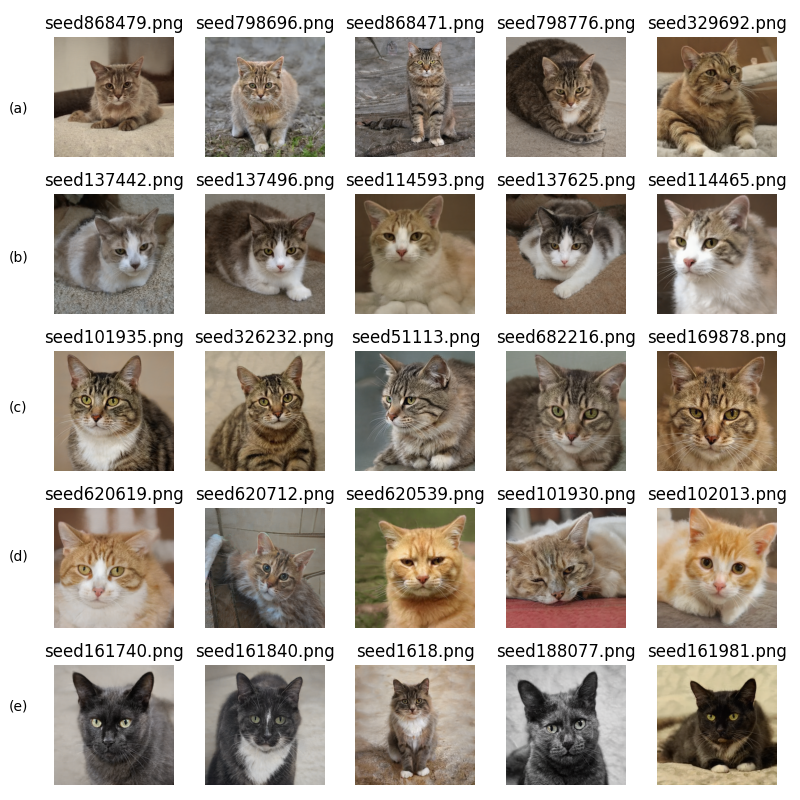

In [16]:
df_subcluster = spark.read.parquet("s3a://bdcc2024-cpt5-finalproject/cats_sub_cluster/")

good_cats = [
    "cats_550k/seed868479.png", "cats_550k/seed798696.png", "cats_550k/seed868471.png", "cats_550k/seed798776.png", "cats_550k/seed329692.png", # black and yellow undertones
    "cats_550k/seed137442.png", "cats_550k/seed137496.png", "cats_550k/seed114593.png", "cats_550k/seed137625.png", "cats_550k/seed114465.png", # white snout and breast
    "cats_550k/seed101935.png", "cats_550k/seed326232.png", "cats_550k/seed51113.png", "cats_550k/seed682216.png", "cats_550k/seed169878.png", # Striped face
    "cats_550k/seed620619.png", "cats_550k/seed620712.png", "cats_550k/seed620539.png", "cats_550k/seed101930.png", "cats_550k/seed102013.png", # white and yellow/gingers
    "cats_550k/seed161740.png", "cats_550k/seed161840.png", "cats_550k/seed1618.png", "cats_550k/seed188077.png", "cats_550k/seed161981.png"  # white to black/gray colored
]

bucket_name = 'bdcc2024-cpt5-finalproject'

# Define the grid size for displaying images
ncols = 5  # This sets the number of columns
nrows = 5

# Create a figure with a specified size
plt.figure(figsize=(8, 8))  # width x height
plt.text(-0.05,0.9,"(a)")
plt.text(-0.05,0.7,"(b)")
plt.text(-0.05,0.5,"(c)")
plt.text(-0.05,0.3,"(d)")
plt.text(-0.05,0.1,"(e)")
plt.axis('off')

# Initialize S3 client
s3_client = boto3.client('s3')

# Loop through each image path in fpath_list, limiting the number of images
for i, image_key in enumerate(good_cats):
    try:
        # Download the image object from S3
        image_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        image_content = image_object['Body'].read()

        # Load image into PIL
        image = Image.open(BytesIO(image_content))

        # Add subplot for the image
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.title(image_key.split('/')[-1])  # Display the image file name as title
    except Exception as e:
        print(f"Error loading image {image_key}: {e}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
%matplot plt


<center><b>Figure 8.</b> Show's Well-defined Cats with Sub-Clusters: <b>(a) Black & Yellow Undertones, (b) White Snout & Breast, (c) Striped (d) White & Ginger Colored (e) Black/Grey to White</b></center>

In **Figure 9.** the five sub-clusters of the `Bad Cats` or those cat images with heavily distorted features are seen. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

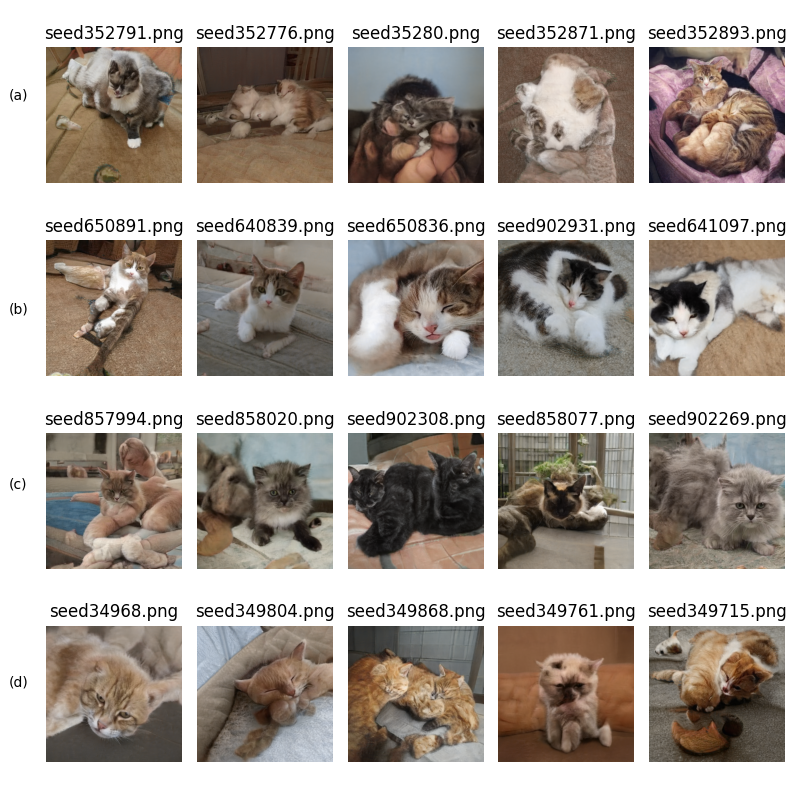

In [14]:
# df_subcluster = spark.read.parquet("s3a://bdcc2024-cpt5-finalproject/cats_sub_cluster/")

bad_cats = [
    'cats_550k/seed352791.png', 'cats_550k/seed352776.png', 'cats_550k/seed35280.png', 'cats_550k/seed352871.png', 'cats_550k/seed352893.png', # Extremely deformed
    'cats_550k/seed650891.png', 'cats_550k/seed640839.png', 'cats_550k/seed650836.png', 'cats_550k/seed902931.png', 'cats_550k/seed641097.png', # White Snout and Chest 
    'cats_550k/seed857994.png', 'cats_550k/seed858020.png', 'cats_550k/seed902308.png', 'cats_550k/seed858077.png', 'cats_550k/seed902269.png', # Black to Yellow/Ginger Colors
    'cats_550k/seed34968.png', 'cats_550k/seed349804.png', 'cats_550k/seed349868.png', 'cats_550k/seed349761.png', 'cats_550k/seed349715.png' # White to Yellow/Ginger Colors
]

bucket_name = 'bdcc2024-cpt5-finalproject'

# Define the grid size for displaying images
ncols = 5  # This sets the number of columns
nrows = 4

# Create a figure with a specified size
plt.figure(figsize=(8, 8))  # width x height
plt.text(-0.05,0.9,"(a)")
plt.text(-0.05,0.62,"(b)")
plt.text(-0.05,0.39,"(c)")
plt.text(-0.05,0.13,"(d)")
plt.axis('off')
# Initialize S3 client
s3_client = boto3.client('s3')

# Loop through each image path in fpath_list, limiting the number of images
for i, image_key in enumerate(bad_cats):
    try:
        # Download the image object from S3
        image_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        image_content = image_object['Body'].read()

        # Load image into PIL
        image = Image.open(BytesIO(image_content))

        # Add subplot for the image
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.title(image_key.split('/')[-1])  # Display the image file name as title
    except Exception as e:
        print(f"Error loading image {image_key}: {e}")

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()
%matplot plt


<center><b>Figure 9.</b> Show's Heavily Distorted Cats with Sub-Clusters: <b>(a) Extremely deformed, (b) White Snout & Breast, (c) Black/to Yellow/Ginger Colors, (d) White to Yellow/Ginger Colors</b></center>


[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='results'>Results and Discussion</a></h1>
</div>

#### Silhouette Score

The silhouette score at least for the first round of clustering (Good and Bad) sat at around 0.25 which could be considered a fairly decent clustering. However, upon sub-clustering the score would drop down even further to a lower score. This team however did not view this too heavily as an obstacle given that, the entire dataset was comprised of mostly cats. If they are all cats, then it should be likely that they could be part of any cluster involving cats. However it is noted that even upon re-running of the clustering, there appeared to be only one instance of an image moving from the Good to the Bad cluster and vice-versa. This suggested that at least for $K = 2$ the clustering was steady.

#### The Good and the Bad

The first round of clustering resulted in two types of clusters "Good Cats" and "Bad Cats". Manual inspection of each cluster showed a clear distinction. The `Good Cats` were those images that showed cats whose features were more defined and distinct. Although there were still some minor deformities, a consequence of these images being all synthetic. However, inspection of what eventually became the `Bad Cats` Cluster resulted in those images that were very clearly distorted. With certain features either missing or even wholely seperate from the cat in the picture. 

This suggested the following:
 - **Highly Seperable Clusters**: The model was able to distinguish between those images that contained highly noticeable deformities versus those that appear well-generated with distinct and clear facial features.

The promising results allowed for the team to further cluster, to verify the possibility of generating even more granular labelling. 

#### Sub - Clustering

The `Good Cats` and `Bad Cats` were further seperated to see examine if within these clusters the model could create even more clusters. Much like the original output the results were highly promising as well.
Sub-clustering still yielded groups of images that were seperable from one another. 

For example as was seen in Figure **8(a)** those cats with black and yellow undertones, which was noticeably different **8(b)** which had cats that had a white snout as well as a white breast area for the fur.
The same could be said for the `Bad Cats` or those cats whose generated images are noticeably distored. Take **Figure 9(c)** Those cats black to ginger colors, versus **9(d)** with white to ginger features. Apart from these differences, the team notes as well the similarities borne out of these labellings. It would appear that even between the `Good Cats` and `Bad Cats` the sub-clustering was done identical features (see: **Figure 8(b)** and **Figure 9(b)**)

Similar to the results from the first layer of clustering, it would appear that given the features extracted the model was still able to cluster based on relatively homogenous, or those features are apparent to the human eye. 

#### Feature Extraction through VGG16

It can also be said that the resulting clusters and the distinctions they had made were a result of VGG16's ability to extract features from the images. This was one of the longer parts of the research team's process. Based on the results however, the use of neural network was an effective one and stands more of a testament to the ability of these neural networks to learn the image and generate features from it.

[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='conclusion'>Conclusion</a></h1>
</div>

This study presents a potential breakthrough in unsupervised learning applications. By leveraging hybrid pipelines, the research successfully demonstrates the ability to generate subclasses within synthetic data. These findings, while currently empirical, hold potential for the future of AI.

Imagine a world where machines can autonomously create their own labels. Manual data labeling, a current bottleneck in the development process, is a  time-consuming and expensive endeavor. Hybrid pipelines for unsupervised learning might be able to alleviate this burden, drastically reducing costs and development timelines.

The implications extend beyond efficiency. This research opens doors for smaller players in the AI landscape. By eliminating the need for massive, pre-labeled datasets, the playing field becomes more even. Smaller companies and individual researchers can now compete and contribute to cutting-edge advancements.

Furthermore, the study's value extends to large language models (LLMs) and generative AI.  These models could leverage these unsupervised labels to  fine-tune their data, leading to significant improvements in various fields. Think of AI systems that can not only process information but also actively refine their understanding of the world through unsupervised learning.

In conclusion, this study represents a first step towards exploring unsupervised learning for data augmentation. By introducing a simple yet potentially effective technique, we open the doors for a more efficient, inclusive, and advanced future for artificial intelligence.



[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='recommendations'>Recommendations</a></h1>
</div>

The study made use of only one feature extraction method as well as a fairly homogenous data set. These act as limitations, and possible avenues to explore as improvements to further the study.
The team recommends the following should the study be continued:

- **Explore other extraction methods**
The study mainly utilized VGG16 due to its relatively small output size so as to avoid data with too many dimensions. However it's smaller output size may not caputre the full complexity of the images, especially for the more fine-grained classifications tasks. Other studies may explore the resulting clusters from using features with a higher number of dimensions. 

- **Introduce Explainable AI techniques**
Much of the difficulty when using machine learning techniques is understanding the logic behind the results, figuring what features were the deciding factor for each factor. Especially in this case with unsupervised learning, there is a lot that is left to the model, and its important for users to trust the decision the machine makes when clustering.This would allow for added insight as to how the clusters were formed and allow a sort of verification between both the user and the machine what labels should be considered. Specifically, methods like Grad-CAM (Gradient-weighted Class Activation Mapping) maybe utilized to visualize and interpret the model's decision-making process.

- **Use a more Diverse Dataset**
The current dataset is quite limited in terms of image classification, being soley on generated cat images. A diverse dataset may introduce a level of complexity that can further enrich the architecture. One could run this hybrid approach on the ImageNet datset which contains a more diverse set of images all with their own labels. A study could drop the labels of the images, and see if the approach would produce similar groupings.



[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='references'>References</a></h1>
</div>



Krishnan, K. (2013) ‘Information management and life cycle for Big Data’, Data Warehousing in the Age of Big Data, pp. 241–250. doi:10.1016/b978-0-12-405891-0.00012-x. 


Pant, D., & Bista, R. (2021). Image-based malware classification
using deep convolutional neural network and transfer learning.
2021 3rd International Conference on Advanced Information Science and System (AISS 2021), 1–6

Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.
[ref]: #top
[Back to Table of Contents][ref]

<div class="custom-header">
    <h1 class="small-caps"><a name='appendix'>Appendix</a></h1>
</div>




[ref]: #top
[Back to Table of Contents][ref]

<div style="display: flex; justify-content: center; align-items: center; flex-wrap: wrap;">
    <figure style="width: 50%; margin: 10px;">
        <img src="Figure8.png" style="width: 100%;"/>
        <figcaption style="text-align: center;"><strong>Figure 10</strong>: White Snout & Breast Images</figcaption>
    </figure>
    <figure style="width: 50%; margin: 10px;">
        <img src="Figure9.png" style="width: 100%;"/>
        <figcaption style="text-align: center;"><strong>Figure 11</strong>: Black with Yellow Undertones</figcaption>
    </figure>
    <!-- Repeat for each image -->
</div>

<div style="display: flex; justify-content: center; align-items: center; flex-wrap: wrap;">
    <figure style="width: 50%; margin: 10px;">
        <img src="Figure9.png" style="width: 100%;"/>
        <figcaption style="text-align: center;"><strong>Figure 12</strong>: White to Yellow Colors</figcaption>
    </figure>
    <figure style="width: 50%; margin: 10px;">
        <img src="Figure11.png" style="width: 100%;"/>
        <figcaption style="text-align: center;"><strong>Figure 13</strong>: White Snout & Breast</figcaption>
    </figure>
    <!-- Repeat for each image -->
</div>